In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pymc as pm
from scipy.misc import comb

In [2]:
np.random.seed(42)

## Data import and cleaning

In [3]:
study_char = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Study Characteristics", 
                           index_col='RefID', na_values=['-', 'NR'])
outcomes = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Outcomes", 
                           na_values=['ND', 'NR'])
#demographics = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Pt Demographics", na_values=['-', 'NR'])

Data cleaning

In [4]:
# Cast outcomes variables to floats
for col in ('Last FU Mean', 'Last FU SD',):
    outcomes[col] = outcomes[col].astype(float)

In [5]:
# Recode age category
study_char['age_cat'] = study_char.AgeCat.replace({'PRE-K':1, 'SCHOOL':0, 'TEEN':2})

In [6]:
# Fix data label typo
outcomes['Measure Instrument'] = outcomes['Measure Instrument'].replace({'Eyberg Child Behaviour Inventory, problem Subscale': 
                                        'Eyberg Child Behaviour Inventory, Problem Subscale'})
outcomes.Units = outcomes.Units.replace({'scale': 'Scale'})

In [7]:
# Parse followup times and convert to months
split_fut = outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'].apply(lambda x: str(x).split(' ')[:2])
fut_months = [float(time)/52.*(unit=='weeks') or float(time) for time, unit in split_fut]
outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'] = fut_months

We are assumung all CBC Externalizing values over 50 are T-scores, and those under 50 are raw scores. This recodes those observations.

In [8]:
cbce_ind = outcomes['Measure Instrument'].apply(lambda x: x.startswith('Child Behavior Checklist, Externalizing'))
under_50 = outcomes['BL Mean']<50
outcomes.loc[cbce_ind & (under_50^True), 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing (T Score)'
outcomes.loc[cbce_ind & under_50, 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing'

Recode measure instrument variables

In [9]:
instrument = []
subtype = []
units = []

for i,row in outcomes.iterrows():
    separator = row['Measure Instrument'].find(',')
    if separator == -1:
        separator = row['Measure Instrument'].find('-')
    instrument.append(row['Measure Instrument'][:separator])
    s = row['Measure Instrument'][separator+2:]
    paren = s.find('(')
    if paren > -1:
        subtype.append(s[:paren-1])
        units.append(s[paren+1:-1])
    else:
        subtype.append(s)
        if s.endswith('scale'):
            units.append('Scale')
        else:
            units.append('Score')
            
new_cols = pd.DataFrame({'instrument': instrument, 'subtype': subtype, 
                         'units': units}, index=outcomes.index)

In [10]:
outcomes['Measure Instrument'].value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            69
Eyberg Child Behaviour Inventory, Problem Subscale              49
Child Behavior Checklist, Externalizing (T Score)               34
Child Behavior Checklist, Externalizing                         11
Strengths and Difficulties Questionnaire, Total Score           10
Strengths and Difficulties Questionnaire- Conduct Problems Scale    10
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)    10
Child Behavior Checklist, Conduct Problems (T Score)             6
Child Behavior Checklist, Aggression                             4
Eyberg Child Behaviour Inventory, Problem Subscale (T Score)     4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
DSM IV                                                           2
Child Behavior Checklist, Rulebreaking                           2
Strengths and Difficulties Questionnaire- Hyperactivity Scale     2
Child Behavior Checklist, Conduct Problems       

In [11]:
new_cols.head()

,instrument,subtype,units
0,Child Behavior Checklist,Aggression,Score
1,Child Behavior Checklist,Aggression,Score
2,Child Behavior Checklist,Aggression,Score
3,Child Behavior Checklist,Aggression,Score
4,Child Behavior Checklist,Conduct Problems,Score


In [12]:
# Append new columns
outcomes = outcomes.join(new_cols)

In [13]:
outcomes.intvn.value_counts()

wlc              47
tau              39
iypt             32
pcit             16
iyptndiyct        8
pppsd             7
mst               5
ppcp              4
modularndn        4
pppo              4
it                4
iyct              4
pmto              3
pmtndp            3
pcitc             3
spokes            3
pppe              3
snap              3
projndsupport     2
pmtsd             2
pcitabb           2
setpc             2
hncte             2
pmtpa             2
hncstd            2
pmtnds            2
pstnds            1
modularndcomm     1
scip              1
modularndclin     1
mcfi              1
cpp               1
coaching          1
pppstd            1
kitkashrut        1
iyptadv           1
hitkashrut        1
itpt              1
sst               1
cbt               1
hnc               1
dtype: int64

## Data summaries

Cross-tabulation of the outcome counts by measure instrument

In [14]:
pd.crosstab(outcomes['instrument'], outcomes['Outcome'])

Outcome,"01 Behavior, disruptive","02 Behavior, aggression","06 Behavior, fighting, destruction, violation","08 Behavior, other"
instrument,,,,
Child Behavior Checklist,53,4,2,0
DSM I,2,0,0,0
Eyberg Child Behaviour Inventory,132,0,0,0
Strengths and Difficulties Questionnaire,10,0,0,20


Distribution of age categories

In [15]:
study_char.AgeCat.value_counts()

SCHOOL    39
PRE-K     26
TEEN      14
dtype: int64

Frequencies of various intervention types

In [16]:
study_char['Intervention Type'].value_counts()

PHARM                                                           19
IY-PT                                                            9
MST                                                              7
PCIT                                                             5
IY-PT + IY-CT                                                    4
BSFT                                                             3
PMTO                                                             3
Triple P (enhanced)                                              3
IY-PT (nurse led)                                                2
CBT                                                              2
PT                                                               2
PCIT-ABB                                                         2
Triple-P (self-directed)                                         2
OTH: Intensive treatment                                         2
SCIP (Social cognitive (Dodge's))                             

## Extract variables of interest and merge tables

In [17]:
KQ1 = study_char[study_char.KQ=='KQ1']

In [18]:
study_varnames = ['Year', 'age_cat', 'Geographic setting', 'Age mean (years) ', 'Age SD (years)', 
              'Age min (years)', 'Age max (years)', 'Proportion Male (%)']

study_vars = KQ1[study_varnames].rename(columns={'Geographic setting': 'country', 
                           'Age mean (years) ': 'age_mean', 
                           'Age SD (years)': 'age_sd', 
                           'Age min (years)': 'age_min', 
                           'Age max (years)': 'age_max', 
                           'Proportion Male (%)': 'p_male'})

In [19]:
study_vars.head()

,Year,age_cat,country,age_mean,age_sd,age_min,age_max,p_male
RefID,,,,,,,,
23,2013,1,USA,2.80,0.61,2,4,62
100,2013,2,USA,14.60,1.30,11,18,83
103,2013,1,USA,5.67,1.72,3,8,53
141,2013,0,USA,9.90,1.30,8,11,73
156,2013,2,Netherlands,16.00,1.31,12,18,73


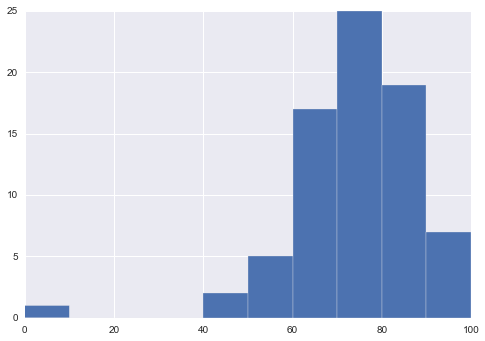

In [20]:
study_vars.p_male.hist()

Proportion missing

In [21]:
study_vars.isnull().mean(0).round(2)

Year        0.00
age_cat     0.00
country     0.00
age_mean    0.12
age_sd      0.19
age_min     0.06
age_max     0.08
p_male      0.01
dtype: float64

Will assume the mean age for those which are missing is simply the midpoint between minimum and maximum values

In [22]:
est_means = study_vars.apply(lambda x: x.age_min + (x.age_max - x.age_min) / 2, axis=1)[study_vars.age_mean.isnull()]
study_vars.loc[study_vars.age_mean.isnull(), 'age_mean'] = est_means

study_vars.age_mean.isnull().sum()

2

In [23]:
outcomes_varnames = ['Ref ID', 'Measure Instrument', 'instrument', 'subtype', 'units', 
                     'intvn', 'cc', 'pc', 'fc',
                     'BL N', 'BL Mean', 'BL SD', 
                     'EOT \nN', 'EOT Mean', 'EOT \nSD', 'Last FU Time', 'Last FU N', 
                     'Last FU Mean', 'Last FU SD', 'CS Group N', 'CS Mean', 'CS SD']

In [24]:
outcomes_vars = outcomes[outcomes_varnames].rename(columns={'Ref ID': 'RefID', 
                                                                       'Measure Instrument': 'measure_instrument',
                                                                       'cc': 'child_component',
                                                                       'pc': 'parent_component',
                                                                       'fc': 'family_component',
                                                                       'oc': 'other_component',
                                                                       'BL N': 'baseline_n',
                                                                       'BL Mean': 'baseline_mean',
                                                                       'BL SD': 'baseline_sd', 
                                                                       'EOT \nN': 'end_treat_n', 
                                                                       'EOT Mean': 'end_treat_mean', 
                                                                       'EOT \nSD': 'end_treat_sd', 
                                                                       'Last FU Time': 'followup_time', 
                                                                       'Last FU N': 'followup_n',
                                                                       'Last FU Mean': 'followup_mean', 
                                                                       'Last FU SD': 'followup_sd', 
                                                                       'CS Group N': 'change_n',
                                                                       'CS Mean': 'change_mean',
                                                                       'CS SD': 'change_sd'})

Recode intervention clasification

In [25]:
outcomes_vars.isnull().sum()

RefID                   0
measure_instrument      0
instrument              0
subtype                 0
units                   0
intvn                   0
child_component         0
parent_component        0
family_component        0
baseline_n              2
baseline_mean          15
baseline_sd            23
end_treat_n            68
end_treat_mean         59
end_treat_sd           66
followup_time          19
followup_n             90
followup_mean         105
followup_sd           113
change_n              211
change_mean           218
change_sd             223
dtype: int64

In [26]:
control = ((outcomes_vars.child_component^True) & 
           (outcomes_vars.parent_component^True) & 
           (outcomes_vars.family_component^True)).astype(int)
child_only = ((outcomes_vars.child_component) & 
              (outcomes_vars.parent_component^True) & 
              (outcomes_vars.family_component^True)).astype(int)
parent_only = ((outcomes_vars.child_component^True) & 
               (outcomes_vars.parent_component) & 
               (outcomes_vars.family_component^True)).astype(int)
outcomes_vars.ix[child_only.astype(bool), ['child_component', 'parent_component', 'family_component']]

,child_component,parent_component,family_component
8,1,0,0
27,1,0,0
28,1,0,0
35,1,0,0
49,1,0,0
50,1,0,0
117,1,0,0
118,1,0,0


In [27]:
multi_component = ((parent_only^True) & (child_only^True) & (control^True)).astype(int)

outcomes_vars['child_only'] = child_only
outcomes_vars['parent_only'] = parent_only
outcomes_vars['multi_component'] = multi_component

Obtain subset with non-missing EOT data

In [28]:
eot_subset = outcomes_vars[outcomes_vars.end_treat_mean.notnull() & outcomes_vars.end_treat_sd.notnull()].copy()

Calculate EOT difference

In [29]:
eot_subset['eot_diff_mean'] = eot_subset.end_treat_mean - eot_subset.baseline_mean

In [30]:
eot_subset['eot_diff_sd'] = eot_subset.baseline_sd + eot_subset.end_treat_sd

In [31]:
eot_subset['eot_diff_n'] = eot_subset[['baseline_n', 'end_treat_n']].min(1)

Distribution of baseline means among outcome metrics

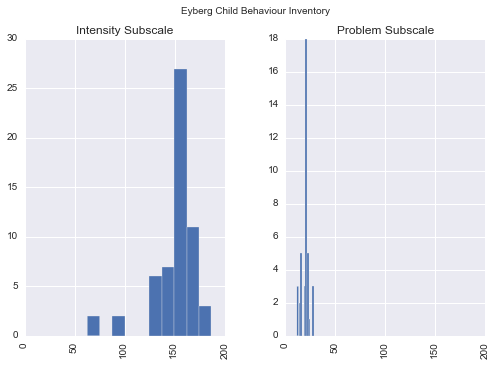

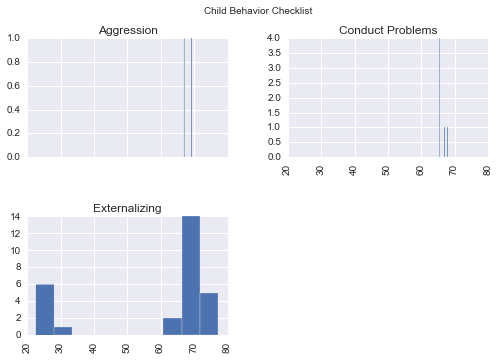

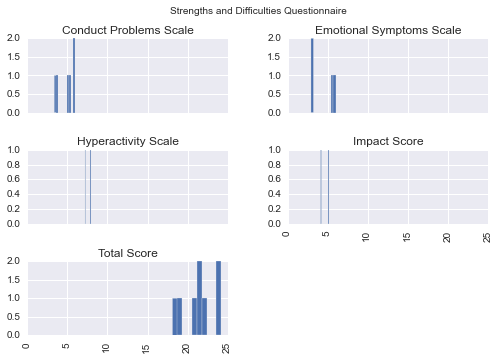

In [32]:
for instrument in ('Eyberg Child Behaviour Inventory', 
                   'Child Behavior Checklist', 
                   'Strengths and Difficulties Questionnaire'):
    eot_subset[eot_subset.instrument==instrument]['baseline_mean'].hist(by=eot_subset['subtype'], 
                                                                              sharex=True)
    plt.suptitle(instrument);

In [33]:
eot_subset.instrument.value_counts()

Eyberg Child Behaviour Inventory            98
Child Behavior Checklist                    36
Strengths and Difficulties Questionnaire    22
dtype: int64

In [34]:
eot_subset[eot_subset.RefID==441]

,RefID,measure_instrument,instrument,subtype,units,intvn,child_component,parent_component,family_component,baseline_n,...,followup_sd,change_n,change_mean,change_sd,child_only,parent_only,multi_component,eot_diff_mean,eot_diff_sd,eot_diff_n
65,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,iypt,0,1,0,32,...,NaN,NaN,NaN,NaN,0,1,0,-31.40,46.80,32
66,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,wlc,0,0,0,20,...,NaN,NaN,NaN,NaN,0,0,0,-5.80,49.60,20
146,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,iypt,0,1,0,24,...,NaN,NaN,NaN,NaN,0,1,0,-9.70,12.02,24
147,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,wlc,0,0,0,17,...,NaN,NaN,NaN,NaN,0,0,0,-2.88,14.59,17


Several studies use multiple instruments and metrics within instruments

In [35]:
eot_subset.groupby(['RefID', 'instrument'])['subtype'].value_counts()

RefID  instrument                                                        
103    Eyberg Child Behaviour Inventory          Intensity Subscale          2
                                                 Problem Subscale            2
371    Eyberg Child Behaviour Inventory          Intensity Subscale          2
                                                 Problem Subscale            2
441    Eyberg Child Behaviour Inventory          Intensity Subscale          2
                                                 Problem Subscale            2
475    Eyberg Child Behaviour Inventory          Intensity Subscale          2
539    Child Behavior Checklist                  Aggression                  2
                                                 Externalizing               2
564    Eyberg Child Behaviour Inventory          Intensity Subscale          2
                                                 Problem Subscale            2
836    Strengths and Difficulties Questionnaire  Total Sc

In [36]:
pd.crosstab(eot_subset.instrument, eot_subset.subtype)

subtype,Aggression,Conduct Problems,Conduct Problems Scale,Emotional Symptoms Scale,Externalizing,Hyperactivity Scale,Impact Score,Intensity Subscale,Problem Subscale,Total Score
instrument,,,,,,,,,,
Child Behavior Checklist,2,6,0,0,28,0,0,0,0,0
Eyberg Child Behaviour Inventory,0,0,0,0,0,0,0,58,40,0
Strengths and Difficulties Questionnaire,0,0,6,4,0,2,2,0,0,8


In [37]:
x = eot_subset[eot_subset.instrument=='Eyberg Child Behaviour Inventory']
pd.crosstab(x.instrument, x.subtype)

subtype,Intensity Subscale,Problem Subscale
instrument,,
Eyberg Child Behaviour Inventory,58,40


In [38]:
x = eot_subset[eot_subset.instrument=='Child Behavior Checklist']
pd.crosstab(x.instrument, x.subtype)

subtype,Aggression,Conduct Problems,Externalizing
instrument,,,
Child Behavior Checklist,2,6,28


In [39]:
x = eot_subset[eot_subset.instrument=='Strengths and Difficulties Questionnaire']
pd.crosstab(x.instrument, x.subtype)

subtype,Conduct Problems Scale,Emotional Symptoms Scale,Hyperactivity Scale,Impact Score,Total Score
instrument,,,,,
Strengths and Difficulties Questionnaire,6,4,2,2,8


Merge study variables and outcomes

In [40]:
merged_vars = study_vars.merge(eot_subset, left_index=True, right_on='RefID')
merged_vars.shape

(154, 36)

For now, restrict to the three most prevalent metrics.

In [41]:
merged_vars.measure_instrument.value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            54
Eyberg Child Behaviour Inventory, Problem Subscale              40
Child Behavior Checklist, Externalizing (T Score)               19
Strengths and Difficulties Questionnaire, Total Score            8
Child Behavior Checklist, Externalizing                          7
Strengths and Difficulties Questionnaire- Conduct Problems Scale     6
Child Behavior Checklist, Conduct Problems (T Score)             6
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)     4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
Strengths and Difficulties Questionnaire- Hyperactivity Scale     2
Child Behavior Checklist, Aggression                             2
Strengths and Difficulties Questionnaire- Impact Score           2
dtype: int64

Take only the top 3 measures

In [42]:
top_measures = 3

In [43]:
analysis_subset = merged_vars[merged_vars.measure_instrument.isin(merged_vars.measure_instrument.value_counts().index[:top_measures])]
analysis_subset.groupby('measure_instrument')['baseline_mean'].max()

measure_instrument
Child Behavior Checklist, Externalizing (T Score)        77.10
Eyberg Child Behaviour Inventory, Intensity Subscale    186.44
Eyberg Child Behaviour Inventory, Problem Subscale       28.62
Name: baseline_mean, dtype: float64

measure_instrument
Child Behavior Checklist, Externalizing (T Score)       Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Intensity Subscale    Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Problem Subscale      Axes(0.125,0.125;0.775x0.775)
Name: baseline_mean, dtype: object

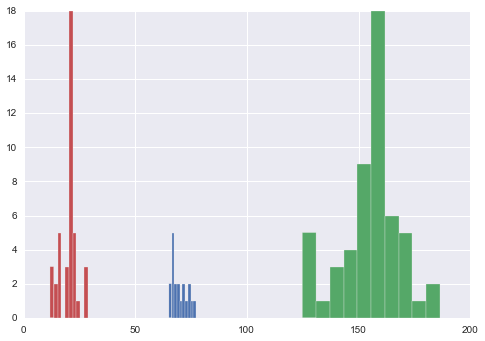

In [44]:
analysis_subset.groupby('measure_instrument').baseline_mean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1197e2cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119b14cf8>]], dtype=object)

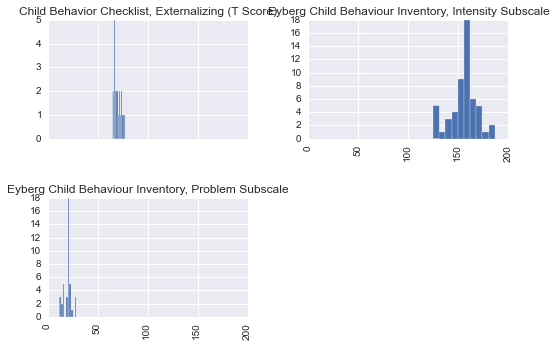

In [45]:
analysis_subset['baseline_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119b9aef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119546b38>]], dtype=object)

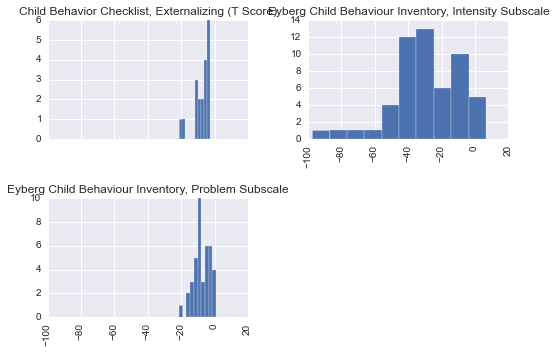

In [46]:
analysis_subset['eot_diff_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

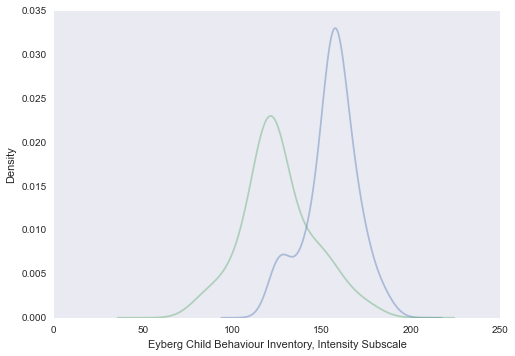

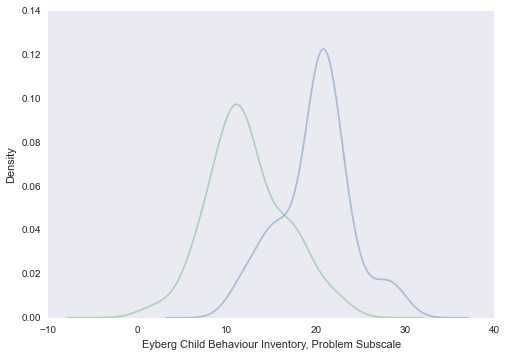

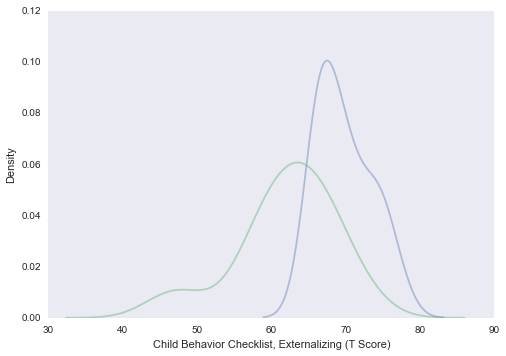

In [47]:
for x in analysis_subset.measure_instrument.unique():
    plt.figure()
    analysis_subset[analysis_subset.measure_instrument==x].baseline_mean.plot(kind='kde', alpha=0.4, grid=False)
    analysis_subset[analysis_subset.measure_instrument==x].end_treat_mean.plot(kind='kde', alpha=0.4, grid=False)
    plt.gca().set_xlabel(x)

## Meta-analysis

Number of studies in analysis subset

In [48]:
unique_studies = analysis_subset.RefID.unique().tolist()
len(unique_studies)

25

In [49]:
analysis_subset.RefID.unique()

array([ 103,  371,  441,  539,  564,  899, 1236, 1245, 1511, 1585, 1875,
       2092, 2117, 2219, 3211, 3225, 3399, 3495, 3687, 3716, 3766, 3915,
       3960, 7109, 7723])

In [54]:
analysis_subset.groupby(['RefID', 'measure_instrument'])['measure_instrument'].count().unstack().fillna(0)

measure_instrument,"Child Behavior Checklist, Externalizing (T Score)","Eyberg Child Behaviour Inventory, Intensity Subscale","Eyberg Child Behaviour Inventory, Problem Subscale"
RefID,,,
103,0,2,2
371,0,2,2
441,0,2,2
539,2,0,0
564,0,2,2
899,3,3,3
1236,0,6,6
1245,2,0,0
1511,3,0,0


Study counts by 

In [55]:
analysis_subset.columns

Index(['Year', 'age_cat', 'country', 'age_mean', 'age_sd', 'age_min', 'age_max', 'p_male', 'RefID', 'measure_instrument', 'instrument', 'subtype', 'units', 'intvn', 'child_component', 'parent_component', 'family_component', 'baseline_n', 'baseline_mean', 'baseline_sd', 'end_treat_n', 'end_treat_mean', 'end_treat_sd', 'followup_time', 'followup_n', 'followup_mean', 'followup_sd', 'change_n', 'change_mean', 'change_sd', 'child_only', 'parent_only', 'multi_component', 'eot_diff_mean', 'eot_diff_sd', 'eot_diff_n'], dtype='object')

In [56]:
data_by_refid = analysis_subset.groupby('RefID')
data_by_refid.apply(lambda x: (x[['child_component', 'parent_component', 'multi_component']].sum()>1)).sum()

child_component      7
parent_component    19
multi_component      6
dtype: int64

In [57]:
data_by_refid.apply(lambda x: (x[['child_component', 'parent_component', 'multi_component']].sum(1)==0).sum()>0).astype(int)

RefID
103      0
371      1
441      1
539      1
564      1
899      1
1236     1
1245     0
1511     1
1585     1
1875     1
2092     1
2117     1
2219     1
3211     1
3225     1
3399     1
3495     1
3687     1
3716     1
3766     1
3915     1
3960     0
7109     1
7723     1
dtype: int64

In [58]:
data_by_refid.apply(lambda x: x.age_cat.unique()[0]).value_counts()

1    14
0    10
2     1
dtype: int64

We are restricting the analysis to the 4 most prevalent measure instruments in the database.

In [59]:
unique_measures = analysis_subset.measure_instrument.unique().tolist()
k = len(unique_measures)
unique_measures

['Eyberg Child Behaviour Inventory, Intensity Subscale',
 'Eyberg Child Behaviour Inventory, Problem Subscale',
 'Child Behavior Checklist, Externalizing (T Score)']

Three intervention components were coded:

* `child_component`
* `parent_component`
* `multi_component`

In [55]:
p_male, age_cat, intvn = analysis_subset[['p_male', 'age_cat', 'intvn']].values.T
child_only, parent_only, multi_component = analysis_subset[['child_only', 'parent_only', 
                                                                       'multi_component']].values.T

change_n, change_mean, change_sd = analysis_subset[['eot_diff_n', 'eot_diff_mean', 'eot_diff_sd']].values.T

In [56]:
school = (analysis_subset.age_cat.values==0).astype(int)
pre_k = (analysis_subset.age_cat.values==1).astype(int)
teen = (analysis_subset.age_cat.values==2).astype(int)

The response variable is a multivariate normal of dimension k=3, for each of the measure instruments.

$$\left({
\begin{array}{c}
  {m_1}\\
  {m_2}\\
  {m_3}
\end{array}
}\right)_i \sim\text{MVN}(\mathbf{\mu},\Sigma)$$

Means for each study are a draw from a multivariate normal.

In [57]:
wishart = False

mu = pm.Normal('mu', 0, 0.001, value=[0]*k)

if wishart:
    T = pm.Wishart('T', k+1, np.eye(k), value=np.eye(k))
    
    m = [pm.MvNormal('m_{}'.format(i), mu, T, value=[0]*k) for i in range(len(unique_studies))]
else:
    sigmas = pm.Uniform('sigmas', 0, 100, value=[10]*k)
    rhos = pm.Uniform('rhos', -1, 1, value=[0]*int(comb(k, 2)))

    Sigma = pm.Lambda('Sigma', lambda s=sigmas, r=rhos: np.array([[s[0]**2, s[0]*s[1]*r[0], s[0]*s[2]*r[1]],
                                                                 [s[0]*s[1]*r[0], s[1]**2, s[1]*s[2]*r[2]],
                                                                 [s[0]*s[2]*r[1], s[1]*s[2]*r[2], s[2]**2]]))
    
    m = [pm.MvNormalCov('m_{}'.format(i), mu, Sigma, value=[0]*k) for i in range(len(unique_studies))]



Unique intervention labels for each component; we will use these for component random effects.

In [58]:
unique_child_intvn = np.unique(intvn[child_only.astype(bool)]).tolist()
unique_parent_intvn = np.unique(intvn[parent_only.astype(bool)]).tolist()
unique_multi_intvn = np.unique(intvn[multi_component.astype(bool)]).tolist()

In [59]:
# Indices to random effect labels
child_component_index = [unique_child_intvn.index(x) for x in intvn[child_only.astype(bool)]]
parent_component_index = [unique_parent_intvn.index(x) for x in intvn[parent_only.astype(bool)]]
multi_component_index = [unique_multi_intvn.index(x) for x in intvn[multi_component.astype(bool)]]

Treatment component random effects

$$X_i = \left[{
\begin{array}{c}
  {x_c}\\
  {x_p}\\
  {x_f}\\
\end{array}
}\right]_i$$

$$\begin{aligned}
\beta_j^{(c)} &\sim N(\mu_{\beta}^{(c)},\tau_{\beta}^{(c)}) \\
\beta_j^{(p)} &\sim N(\mu_{\beta}^{(p)},\tau_{\beta}^{(p)}) \\
\beta_j^{(f)} &\sim N(\mu_{\beta}^{(f)},\tau_{\beta}^{(f)})
\end{aligned}$$

In [60]:
mu_beta = pm.Normal('mu_beta', 0, 0.001, value=[0]*3)
# sig_beta = pm.Uniform('sig_beta', 0, 100, value=1)
# tau_beta = sig_beta ** -2
tau_beta = pm.Gamma('tau_beta', 1, 0.1, value=1)

beta_c = pm.Normal('beta_c', mu_beta[0], tau_beta, value=[0]*len(unique_child_intvn))
beta_p = pm.Normal('beta_p', mu_beta[1], tau_beta, value=[0]*len(unique_parent_intvn))
beta_m = pm.Normal('beta_m', mu_beta[2], tau_beta, value=[0]*len(unique_multi_intvn))

b_c = pm.Lambda('b_c', lambda b=beta_c: 
             np.array([b[unique_child_intvn.index(x)] if child_only[i] else 0 for i,x in enumerate(intvn)]))
b_p = pm.Lambda('b_p', lambda b=beta_p: 
             np.array([b[unique_parent_intvn.index(x)] if parent_only[i] else 0 for i,x in enumerate(intvn)]))
b_m = pm.Lambda('b_m', lambda b=beta_m: 
             np.array([b[unique_multi_intvn.index(x)] if multi_component[i] else 0 for i,x in enumerate(intvn)]))


In [61]:
best = pm.Lambda('best', lambda b=mu_beta:  (b==b.min()).astype(int))

Interaction of parent and multi-component with pre-k children.

In [62]:
interaction = False

if interaction:
    beta_pk_p = pm.Normal('beta_pk_p', 0, 1e-5, value=0)
    beta_pk_m = pm.Normal('beta_pk_m', 0, 1e-5, value=0)
    b_pk_p = pm.Lambda('b_pk_p', lambda b=beta_pk_p: b * parent_only * pre_k)
    b_pk_m = pm.Lambda('b_pk_m', lambda b=beta_pk_m: b * multi_component * pre_k)

In [63]:
betas = b_c + b_p + b_m 

if interaction:
    betas = betas + b_pk_p + b_pk_m

Covariate effects of age and percent female.

$$\alpha \sim N(0, 1e5)$$

In [64]:
alpha_age = pm.Normal('alpha_age', 0, 1e-5, value=[1,2])

Unique study ID (`RefID`) and measure ID (`measure_instrument`) values.

In [65]:
study_id = [unique_studies.index(x) for x in analysis_subset.RefID]
measure_id = [unique_measures.index(x) for x in analysis_subset.measure_instrument]

Calculate expected response (treatment difference) as a function of treatment and covariates.

$$\theta_i = m_{j[i]k} + X_i \beta + \alpha x_{age}$$ 

In [66]:
baseline_sd = analysis_subset.baseline_sd.values

@pm.deterministic
def theta(m=m, betas=betas, alpha_age=alpha_age):  

    mi = [m[i][j] for i,j in zip(study_id, measure_id)]
    
    age_effect = np.array([alpha_age[a-1] if a else 0 for a in age_cat])
    
    return(mi + baseline_sd*(betas + age_effect))

Expected treatment effect for pre-K undergoing multi-component intervention, measused by Eyberg Child Behaviour Inventory, Intensity Subscale

In [67]:
if wishart:
    baseline = pm.MvNormal('baseline', mu, T, value=[0]*k)
else:
    baseline = pm.MvNormalCov('baseline', mu, Sigma, value=[0]*k)

In [68]:
# ECBI intensity subscale
ecbi_intensity_sd = baseline_sd[np.array(measure_id)==0].mean()

prek_intensity_pred = pm.Lambda('prek_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[0]) )
school_intensity_pred = pm.Lambda('school_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*b )
teen_intensity_pred = pm.Lambda('teen_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[1]) )

intensity_diff = pm.Lambda('intensity_diff', 
                           lambda base=baseline, prek=prek_intensity_pred, school=school_intensity_pred, 
                           teen=teen_intensity_pred: np.array([prek, school, teen])-base[0])
                            

# ECBI problem subscale
ecbi_problem_sd = baseline_sd[np.array(measure_id)==1].mean()

prek_problem_pred = pm.Lambda('prek_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[0]) )
school_problem_pred = pm.Lambda('school_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*b )
teen_problem_pred = pm.Lambda('teen_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[1]) )

problem_diff = pm.Lambda('problem_diff', 
                           lambda base=baseline, prek=prek_problem_pred, school=school_problem_pred, 
                           teen=teen_problem_pred: np.array([prek, school, teen])-base[1])

# CBC T-score
cbct_sd = baseline_sd[np.array(measure_id)==2].mean()

prek_tscore_pred = pm.Lambda('prek_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[0]) )
school_tscore_pred = pm.Lambda('school_tscore_pred', 
                            lambda mu=baseline, b=mu_beta: mu[2] + cbct_sd*b )
teen_tscore_pred = pm.Lambda('teen_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[1]) )

tscore_diff = pm.Lambda('tscore_diff', 
                           lambda base=baseline, prek=prek_tscore_pred, school=school_tscore_pred, 
                           teen=teen_tscore_pred: np.array([prek, school, teen])-base[2])

Finally, the likelihood is just a normal distribution, with the observed standard error of the treatment effect as the standard deviation of the estimates.

$$d_i \sim N(\theta_i, \hat{\sigma}^2)$$

In [69]:
change_se = change_sd/np.sqrt(change_n)

In [70]:
d = pm.Normal('d', theta, change_se**-2, observed=True, value=change_mean)

Posterior predictive samples

In [71]:
# d_sim = pm.Normal('d_sim', theta, change_se**-2, size=len(change_mean))

In [72]:
M = pm.MCMC(locals())
M.use_step_method(pm.AdaptiveMetropolis, m)
M.use_step_method(pm.AdaptiveMetropolis, mu_beta)
M.use_step_method(pm.AdaptiveMetropolis, [beta_c, beta_p, beta_m])

In [73]:
M.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 294.7 sec

In [100]:
M.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 302.6 sec

Summary of estimates of intervention components

In [74]:
if wishart:
    pm.Matplot.plot(T)

Plotting mu_beta_0
Plotting mu_beta_1
Plotting mu_beta_2


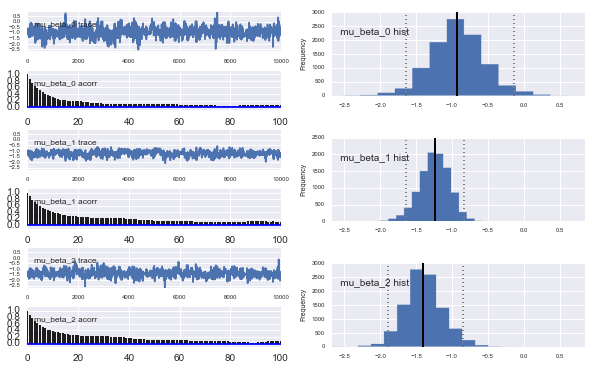

In [75]:
pm.Matplot.plot(mu_beta)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


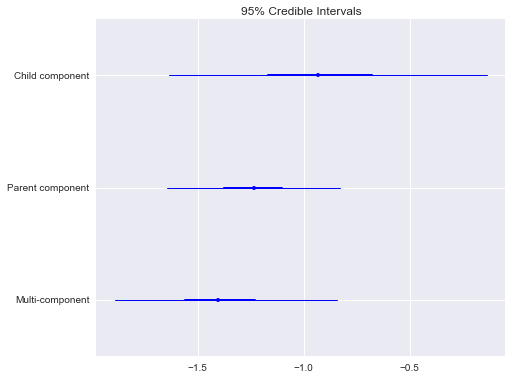

In [76]:
pm.Matplot.summary_plot([mu_beta], custom_labels=['Child component', 'Parent component', 
                                                              'Multi-component'])

In [77]:
mu_beta.summary()


mu_beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.925           0.378            0.017            [-1.635 -0.136]
	-1.245           0.207            0.011            [-1.647 -0.83 ]
	-1.39            0.27             0.014            [-1.892 -0.842]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.674           -1.168          -0.934         -0.677        -0.156
	-1.689           -1.379          -1.236         -1.105        -0.863
	-1.886           -1.562          -1.403         -1.229        -0.823
	


In [78]:
best.summary()


best:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.096            0.295            0.011                  [ 0.  1.]
	0.269            0.443            0.019                  [ 0.  1.]
	0.635            0.481            0.022                  [ 0.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            0.0           1.0
	0.0              0.0             0.0            1.0           1.0
	0.0              0.0             1.0            1.0           1.0
	


Plotting mu_beta_0
Plotting mu_beta_1
Plotting mu_beta_2


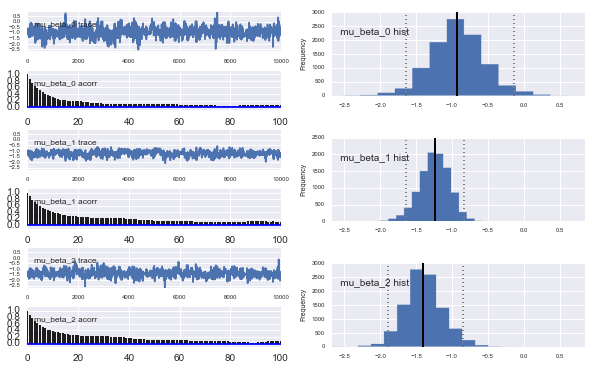

In [79]:
pm.Matplot.plot(mu_beta)

In [80]:
if interaction:
    pm.Matplot.summary_plot([beta_pk_m, beta_pk_p])

Difference means by measure instrument.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


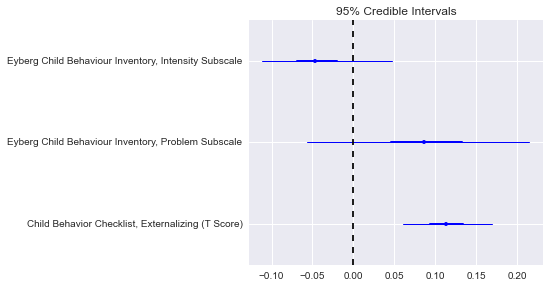

In [81]:
plt.figure(figsize=(24,4))
pm.Matplot.summary_plot([mu], custom_labels=unique_measures)

Plotting mu_0
Plotting mu_1
Plotting mu_2


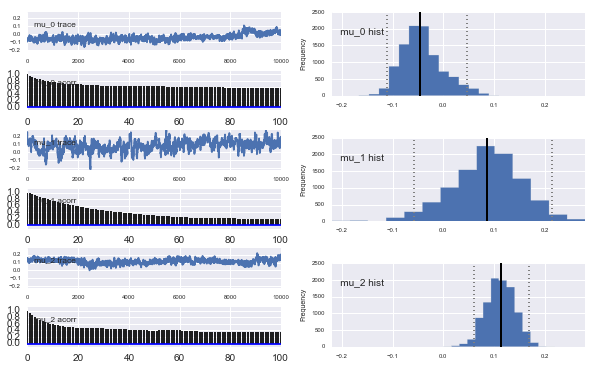

In [82]:
pm.Matplot.plot(mu)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


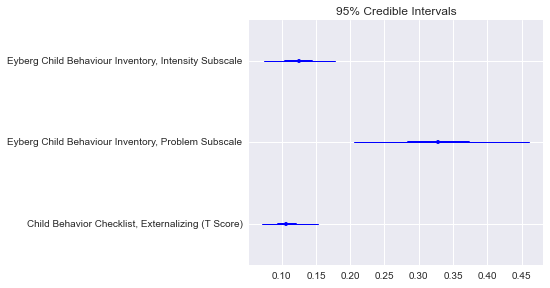

In [83]:
if not wishart:
    plt.figure(figsize=(24,4))
    pm.Matplot.summary_plot([sigmas], custom_labels=unique_measures)

In [106]:
sigmas.summary()


sigmas:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.127            0.026            0.002            [ 0.079  0.176]
	0.219            0.123            0.012            [ 0.068  0.421]
	0.127            0.031            0.002            [ 0.076  0.191]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.081            0.109           0.126          0.143         0.18
	0.078            0.103           0.183          0.329         0.451
	0.079            0.103           0.122          0.145         0.196
	


Plotting sigmas_0
Plotting sigmas_1
Plotting sigmas_2


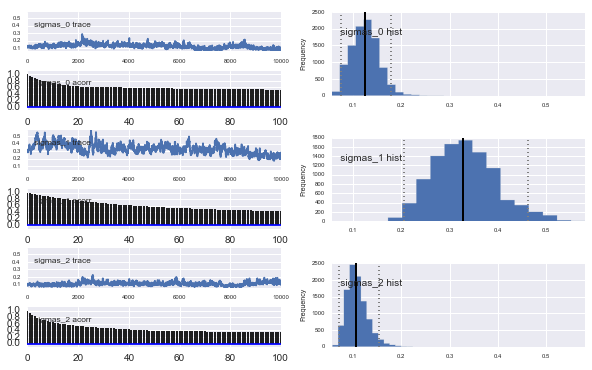

In [84]:
pm.Matplot.plot(sigmas)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


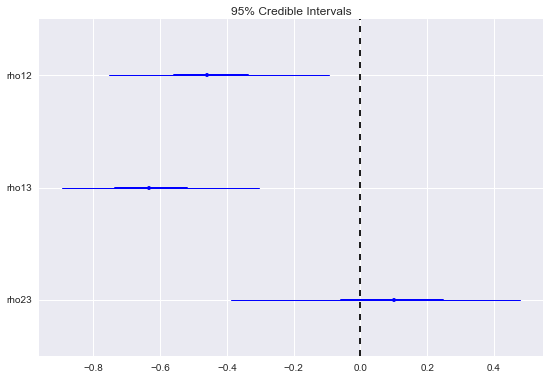

In [85]:
if not wishart:
    pm.Matplot.summary_plot([rhos], custom_labels=['rho12', 'rho13', 'rho23'])

Age effects for pre-k (top) and teen (bottom) groups, relative to pre-teen.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


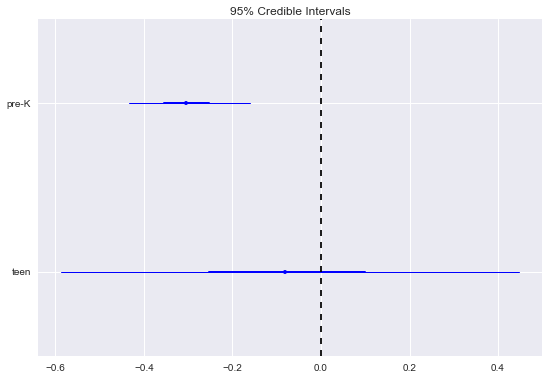

In [86]:
pm.Matplot.summary_plot([alpha_age], custom_labels=['pre-K', 'teen'])

In [87]:
alpha_age.summary()


alpha_age:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.303           0.072            0.004            [-0.434 -0.16 ]
	-0.081           0.267            0.015            [-0.588  0.448]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.438           -0.355          -0.304         -0.254        -0.162
	-0.634           -0.254          -0.081         0.099         0.421
	


Plotting alpha_age_0
Plotting alpha_age_1


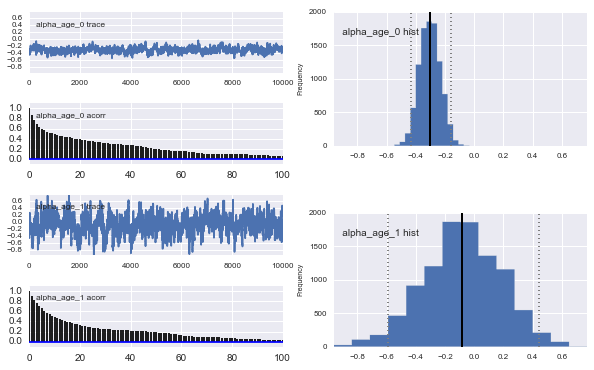

In [88]:
pm.Matplot.plot(alpha_age)

## Outcome Plots

In [89]:
traces = [[school_intensity_pred, prek_intensity_pred, teen_intensity_pred],
          [school_problem_pred, prek_problem_pred, teen_problem_pred],
          [school_tscore_pred, prek_tscore_pred, teen_tscore_pred]]

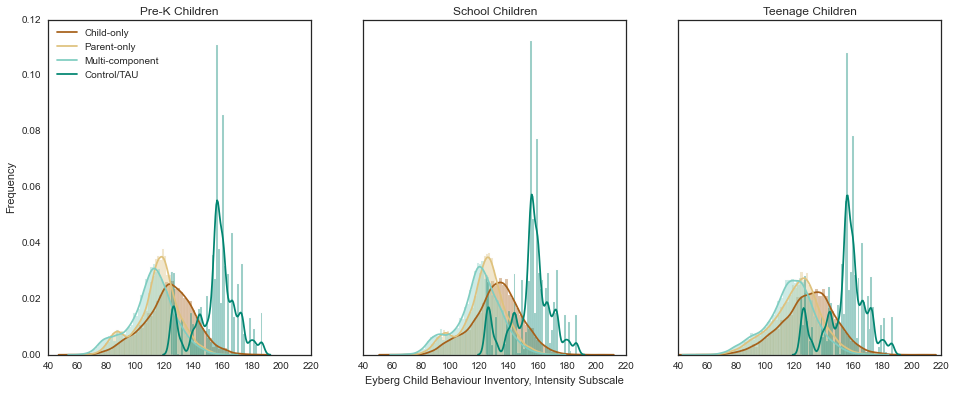

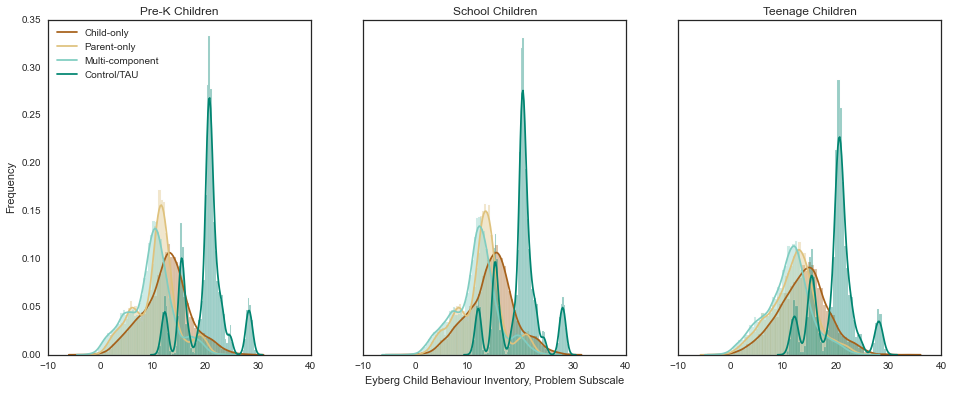

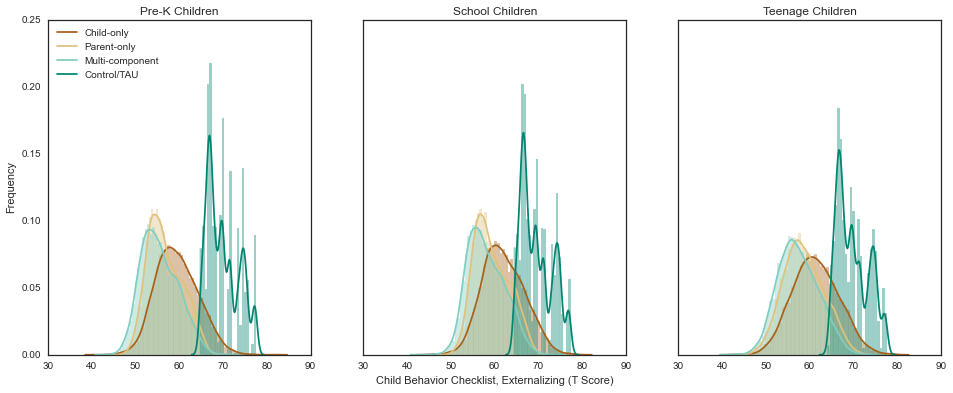

In [90]:
sb.set(style="white", palette="hot")
sb.despine(left=True)

colors = '#a6611a','#dfc27d','#80cdc1','#018571'
# colors = ('#fef0d9','#fdcc8a','#fc8d59','#d7301f')[::-1]
# colors = sb.cubehelix_palette(4, start=2, rot=0, dark=.25, light=.75, reverse=False)

titles = ['Pre-K Children', 'School Children', 'Teenage Children']

for i,measure in enumerate(unique_measures):
    
    f, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)
    measure_traces = traces[i]
    
    for j, trace in enumerate(np.array(measure_traces)[[1,0,2]]):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        g = sb.distplot(x + c1, color=colors[0], ax=axes[j])
        sb.distplot(x + p1, color=colors[1], ax=axes[j])
        sb.distplot(x + m1, color=colors[2], ax=axes[j])
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        sb.distplot(x + baseline.trace()[:, i] + age_effect, color=colors[3], ax=axes[j]);
        g.set_title(titles[j])

        

        if not j:
            g.set_ylabel('Frequency')
            g.legend(g.lines, ['Child-only', 'Parent-only', 'Multi-component', 'Control/TAU'], loc='upper left')
        if j==1:
            g.set_xlabel(measure)

Generate threshold proportions

In [102]:
thresholds = [127, # ECBI, intensity
              11,  # ECBI, problem
              60]  # CBC t-score

age_labels = ['school', 'pre-k', 'teen']

estimates = []

for i,measure in enumerate(unique_measures):
    
    measure_traces = traces[i]
    cutoff = thresholds[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        _child_only = ((x + c1) > cutoff).mean().round(2)
        _parent_only = ((x + p1) > cutoff).mean().round(2)
        _multi_component = ((x + m1) > cutoff).mean().round(2)
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        _control = ((x + baseline.trace()[:, i] + age_effect) > cutoff).mean().round(2)
        
        print('\n{0}, {1}'.format(measure, age_labels[j]))
        print('Child-only: {0}\nParent-only: {1}\nMulti-component: {2}\nControl/TAU: {3}'.format(_child_only, 
                                                                                                 _parent_only,
                                                                                                 _multi_component,
                                                                                                 _control))
        
        estimates.append((measure, age_labels[j], _child_only, _parent_only, _multi_component, _control))
        


Eyberg Child Behaviour Inventory, Intensity Subscale, school
Child-only: 0.63
Parent-only: 0.37
Multi-component: 0.3
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Intensity Subscale, pre-k
Child-only: 0.45
Parent-only: 0.18
Multi-component: 0.15
Control/TAU: 0.92

Eyberg Child Behaviour Inventory, Intensity Subscale, teen
Child-only: 0.56
Parent-only: 0.34
Multi-component: 0.27
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Problem Subscale, school
Child-only: 0.77
Parent-only: 0.69
Multi-component: 0.61
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, pre-k
Child-only: 0.67
Parent-only: 0.5
Multi-component: 0.41
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, teen
Child-only: 0.73
Parent-only: 0.6
Multi-component: 0.54
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), school
Child-only: 0.62
Parent-only: 0.37
Multi-component: 0.31
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), pre-k
Child

In [103]:
thresholds = [127, # ECBI, intensity
              11,  # ECBI, problem
              60]  # CBC t-score

age_labels = ['school', 'pre-k', 'teen']

estimates = []

for i,measure in enumerate(unique_measures):
    
    measure_traces = traces[i]
    cutoff = thresholds[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        _child_only = ((x + c1) > cutoff).mean().round(2)
        _parent_only = ((x + p1) > cutoff).mean().round(2)
        _multi_component = ((x + m1) > cutoff).mean().round(2)
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        _control = ((x + baseline.trace()[:, i] + age_effect) > cutoff).mean().round(2)
        
        print('\n{0}, {1}'.format(measure, age_labels[j]))
        print('Child-only: {0}\nParent-only: {1}\nMulti-component: {2}\nControl/TAU: {3}'.format(_child_only, 
                                                                                                 _parent_only,
                                                                                                 _multi_component,
                                                                                                 _control))
        
        estimates.append((measure, age_labels[j], _child_only, _parent_only, _multi_component, _control))
        


Eyberg Child Behaviour Inventory, Intensity Subscale, school
Child-only: 0.62
Parent-only: 0.38
Multi-component: 0.31
Control/TAU: 0.92

Eyberg Child Behaviour Inventory, Intensity Subscale, pre-k
Child-only: 0.45
Parent-only: 0.19
Multi-component: 0.16
Control/TAU: 0.92

Eyberg Child Behaviour Inventory, Intensity Subscale, teen
Child-only: 0.56
Parent-only: 0.34
Multi-component: 0.26
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Problem Subscale, school
Child-only: 0.78
Parent-only: 0.7
Multi-component: 0.62
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, pre-k
Child-only: 0.66
Parent-only: 0.49
Multi-component: 0.39
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, teen
Child-only: 0.73
Parent-only: 0.61
Multi-component: 0.54
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), school
Child-only: 0.63
Parent-only: 0.37
Multi-component: 0.32
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), pre-k
Chi

In [104]:
estimates

[('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'school',
  0.62,
  0.38,
  0.31,
  0.92000000000000004),
 ('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'pre-k',
  0.45000000000000001,
  0.19,
  0.16,
  0.92000000000000004),
 ('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'teen',
  0.56000000000000005,
  0.34000000000000002,
  0.26000000000000001,
  0.93000000000000005),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'school',
  0.78000000000000003,
  0.69999999999999996,
  0.62,
  1.0),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'pre-k',
  0.66000000000000003,
  0.48999999999999999,
  0.39000000000000001,
  1.0),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'teen',
  0.72999999999999998,
  0.60999999999999999,
  0.54000000000000004,
  1.0),
 ('Child Behavior Checklist, Externalizing (T Score)',
  'school',
  0.63,
  0.37,
  0.32000000000000001,
  1.0),
 ('Child Behavior Checklist, Externalizing (T Score)',
  '

In [105]:
np.savetxt('estimates.csv', np.array([e[2:] for e in estimates]), delimiter='\t', fmt='%1.2f')

In [94]:
pd.DataFrame(estimates, columns=['Instrument', 'Age group', 'Child-only', 
                                 'Parent-only', 'Multi-component', 'TAU/Control']).to_csv('outcome_proportions.csv')

Summary statistics for TAU/control

In [95]:
baseline.summary()


baseline:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.038           0.135            0.004            [-0.312  0.226]
	0.079            0.34             0.006            [-0.574  0.78 ]
	0.111            0.115            0.002            [-0.114  0.341]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.31            -0.124          -0.037         0.05          0.229
	-0.603           -0.135          0.084          0.298         0.755
	-0.124           0.038           0.112          0.185         0.334
	


Summary statistics for intensity subscale

In [96]:
prek_intensity_pred.summary()
school_intensity_pred.summary()
teen_intensity_pred.summary()


prek_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-32.014          10.03            0.48           [-51.306 -11.334]
	-40.351          5.274            0.251            [-51.44 -30.61]
	-44.11           7.049            0.356          [-57.777 -30.08 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-51.726          -38.618         -32.097        -25.799       -11.524
	-51.354          -43.6           -40.306        -36.865       -30.354
	-57.258          -48.697         -44.369        -39.702       -29.366
	

school_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-24.119          9.844            0.452          [-42.541  -3.449]
	-32.457          5.376   

Summary statistics for problem subscale

In [97]:
prek_problem_pred.summary()
school_problem_pred.summary()
teen_problem_pred.summary()


prek_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-7.413           2.382            0.113          [-12.211  -2.733]
	-9.366           1.282            0.059          [-12.004  -6.893]
	-10.247          1.683            0.083          [-13.488  -6.852]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-12.113          -8.98           -7.44          -5.929        -2.586
	-12.029          -10.161         -9.338         -8.502        -6.903
	-13.411          -11.343         -10.313        -9.187        -6.734
	

school_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-5.563           2.338            0.107          [-10.477  -1.109]
	-7.517           1.304          

Summary statistics for t scores

In [98]:
prek_tscore_pred.summary()
school_tscore_pred.summary()
teen_tscore_pred.summary()


prek_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-10.305          3.272            0.156          [-16.586  -3.528]
	-13.021          1.719            0.082          [-16.656  -9.828]
	-14.246          2.299            0.116          [-18.624  -9.585]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-16.703          -12.461         -10.337        -8.277        -3.607
	-16.612          -14.064         -12.999        -11.882       -9.754
	-18.535          -15.739         -14.326        -12.81        -9.406
	

school_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-7.734           3.212            0.147          [-13.8    -0.998]
	-10.45           1.753            

#### Summary statistics for differences.

Each summary corresponds to teh differences between baseline and age x component categories for each outcome. The order is:

- child-only, pre-k
- child-only, school
- child-only, teen
- parent-only, pre-k
- parent-only, school
- parent-only, teen
- multi, pre-k
- multi, school
- multi, teen


In [99]:
intensity_diff.summary()
problem_diff.summary()
tscore_diff.summary()


intensity_diff:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-31.976          10.03            0.48           [-51.371 -11.433]
	-40.314          5.273            0.252          [-51.366 -30.579]
	-44.072          7.049            0.356          [-57.346 -29.736]
	-24.081          9.845            0.452          [-42.55   -3.533]
	-32.419          5.378            0.286          [-42.879 -21.608]
	-36.178          7.023            0.353          [-49.256 -21.919]
	-26.19           12.034           0.595          [-50.881  -4.284]
	-34.528          8.926            0.513          [-52.123 -17.441]
	-38.286          8.939            0.418          [-54.553 -19.629]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-51.627          -38.559         -32.077        -25.81        -11.4